# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling
4. Summary and Conclusion

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set_theme(color_codes=True)

---
## 2. Load data

In [3]:
df = pd.read_csv('./data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

In [4]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, classification_report, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [5]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


In [7]:
y_train.value_counts(True), y_test.value_counts(True)

(churn
 0    0.903871
 1    0.096129
 Name: proportion, dtype: float64,
 churn
 0    0.899781
 1    0.100219
 Name: proportion, dtype: float64)

### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm. 

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging. 

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [8]:
seed = 123
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

In [9]:
# Add model training in here!
model = RandomForestClassifier(random_state=seed, n_estimators=450, min_samples_leaf=2, 
                               min_samples_split=3, max_samples=0.7, max_features=0.15)

__Cross validation to estimate model's performance on test data__

Using a 5-fold cross validation approach we will fit a random forest model by splitting the training data into 5-folds, where at each iterations, 4/5th of the data is used to train a model while the rest 1/5th (validation set) to evaluate model's peformance.

In [10]:
# 5 fold cross validation
res = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv)

In [11]:
res

array([0.6927785 , 0.70421633, 0.65893532, 0.7222747 , 0.68477393])

In [12]:
# mean +- sd AUROC
print(f'{res.mean():.3f}  +- {res.std():.3f}')

0.693  +- 0.021


- Model performance on test data is estimated to be around 0.66 and 0.72

In [13]:
# fit to train data
model.fit(X_train, y_train)

RandomForestClassifier(max_features=0.15, max_samples=0.7, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=450, random_state=123)

### Evaluation

Now let's evaluate how well this trained model is able to predict the values of the test dataset.

In [14]:
# Generate predictions here!
# get model probabilities and predictions
probs = model.predict_proba(X_test)[:,1]
predictions = model.predict(X_test)

In [15]:
# Calculate performance metrics here!
# roc value on test data
roc_auc_score(y_test, probs)

0.6643243899437588

- AUROC value almost similar to that obtained in cross-validation

In [16]:
# model metrics
print(classification_report(y_test, model.predict(X_test), target_names=['Churn-No', 'Churn-Yes']))

              precision    recall  f1-score   support

    Churn-No       0.90      1.00      0.95      3286
   Churn-Yes       0.93      0.04      0.07       366

    accuracy                           0.90      3652
   macro avg       0.92      0.52      0.51      3652
weighted avg       0.91      0.90      0.86      3652



- Performance not good on class of interest.

### Model Diagnostics

In [17]:
# get feature importance
feature_importance = pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values()

In [18]:
top_20 = feature_importance.tail(20)

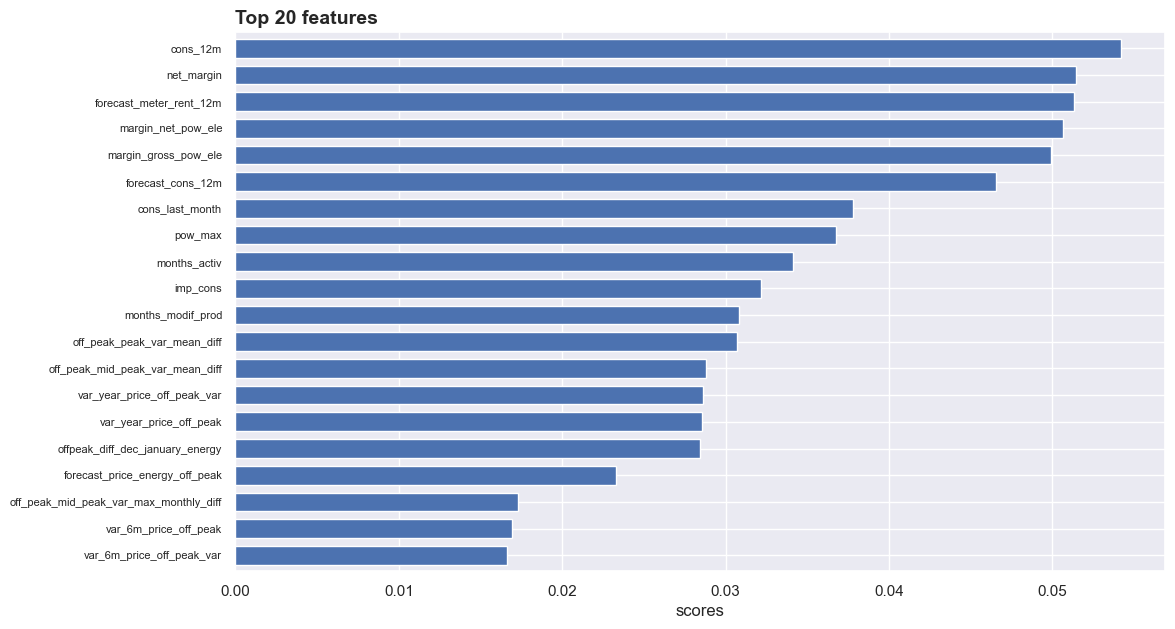

In [19]:
top_20.plot.barh(figsize=(12,7), width=0.7)
plt.xlabel('scores')
plt.yticks(fontsize=8)
plt.title('Top 20 features', fontsize=14, fontweight='bold', loc='left')
plt.show()

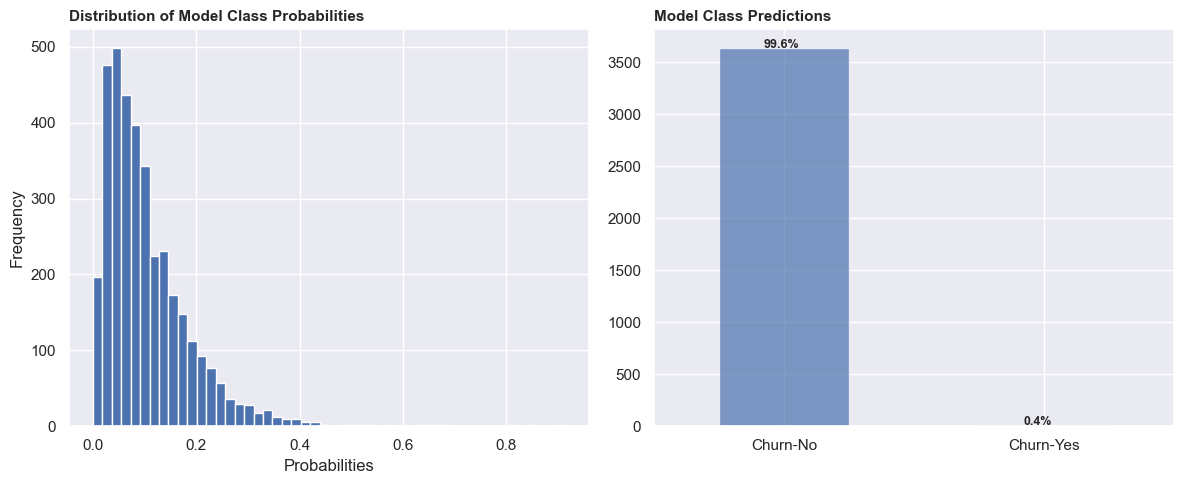

In [20]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].hist(probs, bins=50, edgecolor='w')
ax[0].set_title('Distribution of Model Class Probabilities', loc='left', fontsize=11, fontweight='bold')
ax[0].set(ylabel='Frequency', xlabel='Probabilities')

a = pd.Series(predictions).value_counts().plot(kind='bar', rot=0, ax=ax[1], alpha=0.7)
ax[1].set_title('Model Class Predictions', loc='left', fontsize=11, fontweight='bold')
for i in a.patches:
    val = 100*i.get_height()/len(predictions)
    ax[1].annotate(f'{val:.1f}%', (i.get_x()+0.17, i.get_height()), fontweight='bold', fontsize=9)
plt.xticks(range(2), ['Churn-No', 'Churn-Yes'])

fig.tight_layout()
plt.show()

- Identifying most churned customers to have less likelihood to churn
- Less than 1% out of the 10% of churned customers were identified

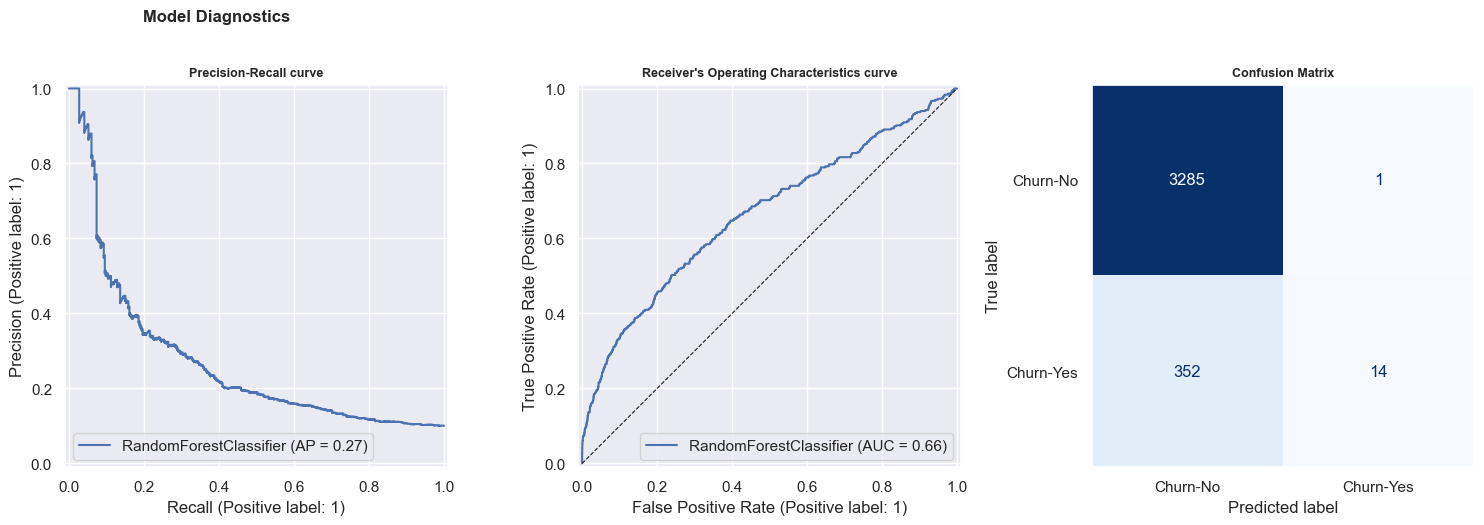

In [21]:
fig, ax = plt.subplots(1,3,figsize=(15,10))
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[0])
ax[0].set_title('Precision-Recall curve', fontsize=9, fontweight='bold')

RocCurveDisplay.from_estimator(model, X_test, y_test, pos_label=1, ax=ax[1])
ax[1].plot([0,1], [0,1], 'k--', lw=0.8)
ax[1].set_title('Receiver\'s Operating Characteristics curve', fontsize=9, fontweight='bold')

metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Churn-No', 'Churn-Yes'], 
                                              cmap='Blues', ax=ax[2], colorbar=False)
ax[2].set_title('Confusion Matrix', fontsize=9, fontweight='bold')
ax[2].grid(False)

fig.suptitle('Model Diagnostics', fontweight='bold', fontsize=12, x=0.15, y=0.75)
fig.tight_layout()
plt.show()

- Model's performance slightly better than a random model (AUROC = 0.5)

- Lowering the threshold (AUPRC-left figure) may help with detecting churn customers. This may be better since it may be beneficial to PowerCo to restrategise on retaining them, since those who won't churn but incorrectly predicted by the model to churn will still remain except in the case where PowerCo may lose some amount in revenue while providing incentives to these customers to retain them.

- 14 out of the 366 churned customers were identified by the model. This represents about 4% of the churned customers indicating that the model is sensitive to identifying about 4% of churned customers. This is known as the recall. On the other hand, the model has a good false positive rate, where only 1 of the 3286 retained customers in the test data was incorrectly classified to churn.

- On the other hand, the precision of the model, given by the fraction of the class of interest (churn class) are contained in the model's predictions for that class of interest. From the confusion matrix, a total of 15 customers were predicted by the model to churn, however, 93% of them were from the class of interest.

- The results from the confusion matrix tells us that the model is doing very well at predicting customers that won't churn. This isn't what PowerCo needs because they want to identify these customers who would churn to come up with ways to keep them and in turn to increase their returns.

---

## 4. __Summary and Conclusion__

Here, we fit a random forest model to predict the probability that a customer would churn from PowerCo. Feature engineering techniques were performed to preprocess data and generate features that could have predictive power. After that, the dataset was split into training and test data where the train data was used to develop a predictive model and the test used to evaluate the performance of the model. 

To estimate the performance of the model on the unseen test dataset, a 5-fold crossvalidation was performed where 4/5th of the training data was used for training and the remaining 1/5th to evaluate performance on a temporary held out data (validation dataset). This was done in 5-iterations. Evaluation was done using the area under the receiver's operating characteristics curve (AUROC)- although other metrics were used. This metric was chosen because we aim to predict the probability of churn. This metric checks the performance of a model at various threshold values. It does this by measuring the true positive rate (which is the recall or the number of samples from the class of interest whose class were correctly predicted) and the false positive rate (which is the fraction of samples from the class of less interest whose class were incorrectly predicted) [(<u>link</u>)](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

After cross-validation, an AUROC score of 0.694 was obtained on average on the validation set used during crossvalidation. After this, the random forest model was fit on the whole training data and then evaluated on the heldout test data. From the result, an AUROC score of 0.664 was obtained. Further diagnostic metrics on the model's performance on the test data were obtained. These metrics include the accuracy, recall and precision and the area under the precision-recall curve (AUPRC) with a score of 0.28. 

Due to the high imbalance in the data, accuracy is not the best metric to use to evaluate model's performance because there's a bias in the model where it tends to focus on the majority class while "paying less attention" to the minority class. However, from the recall, precision and AUROC scores obtained, the random forest model is doing very poorly at identifying customers who would churn. Although the AUROC value is slightly higher than that that would be obtained by a random model (AUROC = 0.5), but having a higher the AUROC value is much better and indicates a better performance of the model. 

Moving on to the distribution of the predicted probabilities, it is found that the model predicts less probabilities of customers churning (probabilities mostly less than 0.2) while out of the total samples on the test data, less than 1% were predicted to have a high probability to churn. In addition to this, the top 20 features used by the model for predictions were obtained. These features include the gross margin on power subscription, the amount of power/electricity consumed by the clients, the forecasted bill of meter rental for the next 12 months, the total net and gross margins, the forecasted electricity consumption for the next 12 months, the subscribed power, the number of months the customer will be activate until Jan 2016 and so on

In conclusion, random forest model is performing not so well at predicting the class of interest (churn). This is mostly as a result of the class imbalance in the dataset. Techniques used for solving the class imbalance problem may be applied to remove model bias and improve the model's sensitivity on the class of interest (churn). Similarly, as we see from the top 20 features, energy or power cost is one reason why customers are likely to churn. Others include the number of months left from contract until a reference date and the difference in off-peak and peak or mid-peak prices, or between peak and mid-peak energy or power prices, etc. As a result, strategies need to be set up to entice customers to stay and probably stabilize price fluctuations. One would be to offer subscription discounts or provide products suitable for these likely-to-churn customers.